## **Recurrent Neural Networks**

## Now we discover a more advanced version of neural networks called Recurrent Neural Networks. There are three very common versions of RNNs:

## SimpleRNN, GRU (Gated Recurrent Unit), and LSTM (Long Short Term Memory).

##In practice, SimpleRNNs are hardly used anymore for a number of problems.

## There are more recurrent architectures i.e. Elman networks, Hopfield networks etc. many are inspired by physics topics....Statistical mechanics, many body systems etc.

## RNNs great for data that has **sequences**, for example:
##- **Time series**
##- **Written text (sequences of words)**
##- **DNA sequences**
##- **Geolocation sequences**

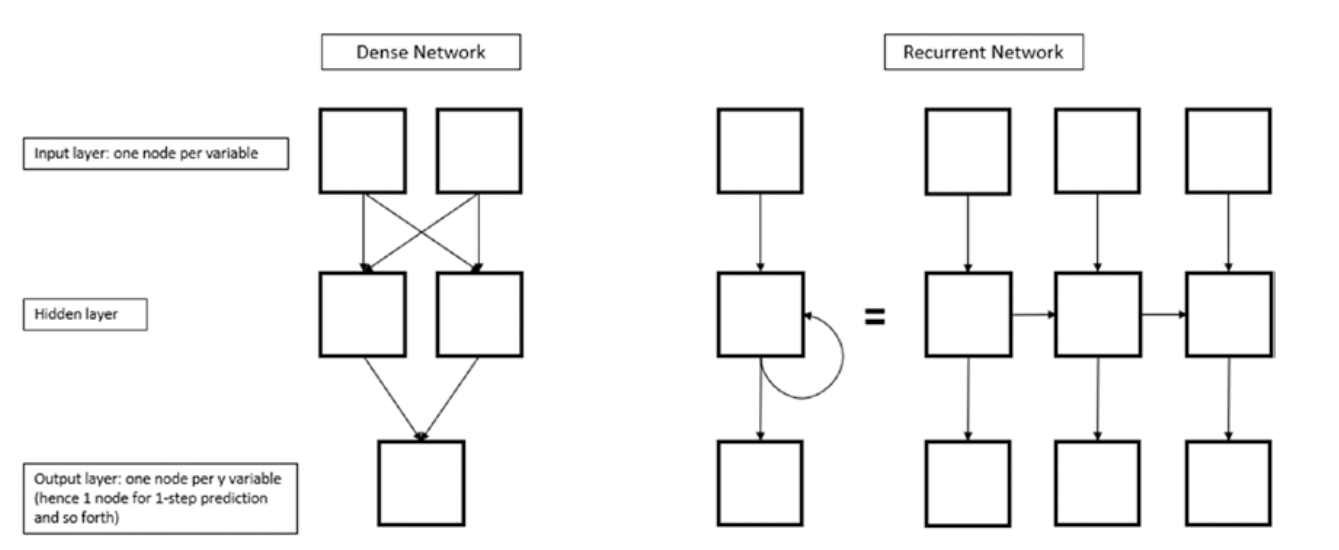

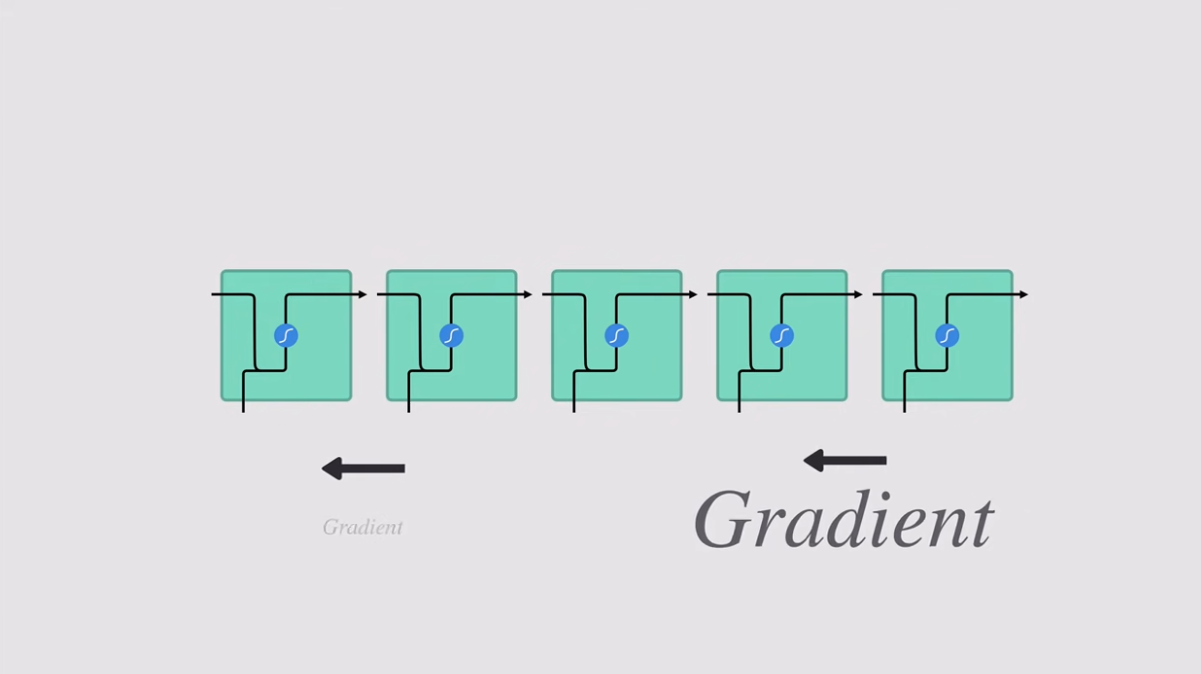

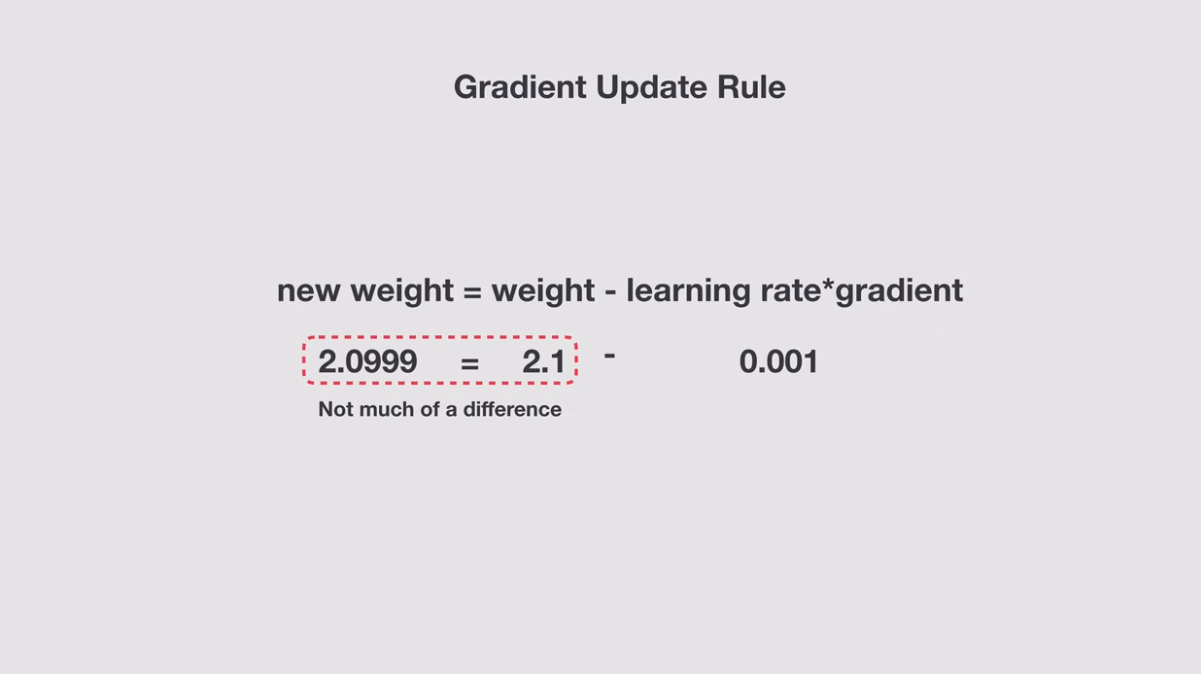

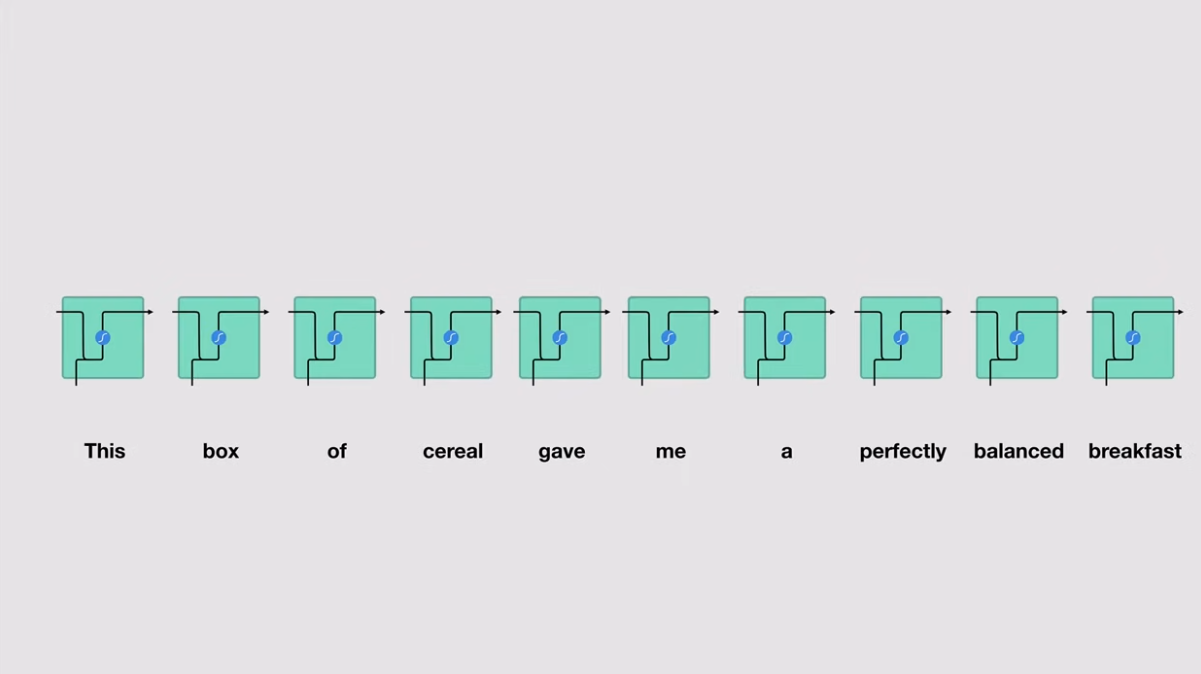

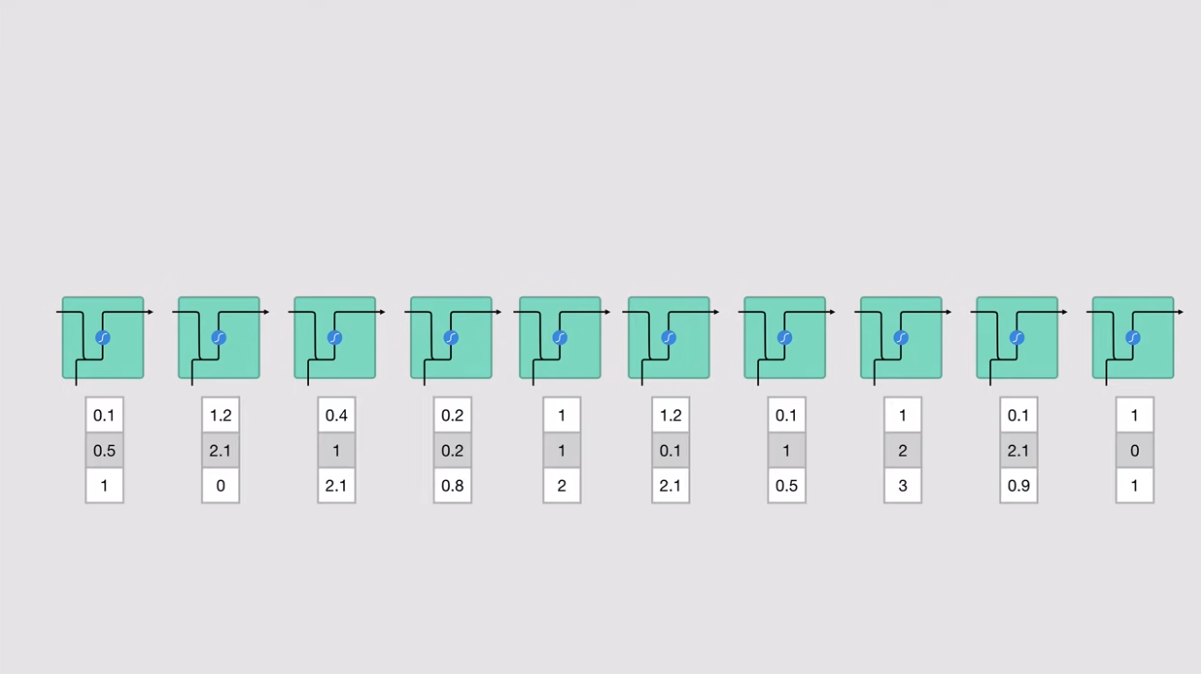

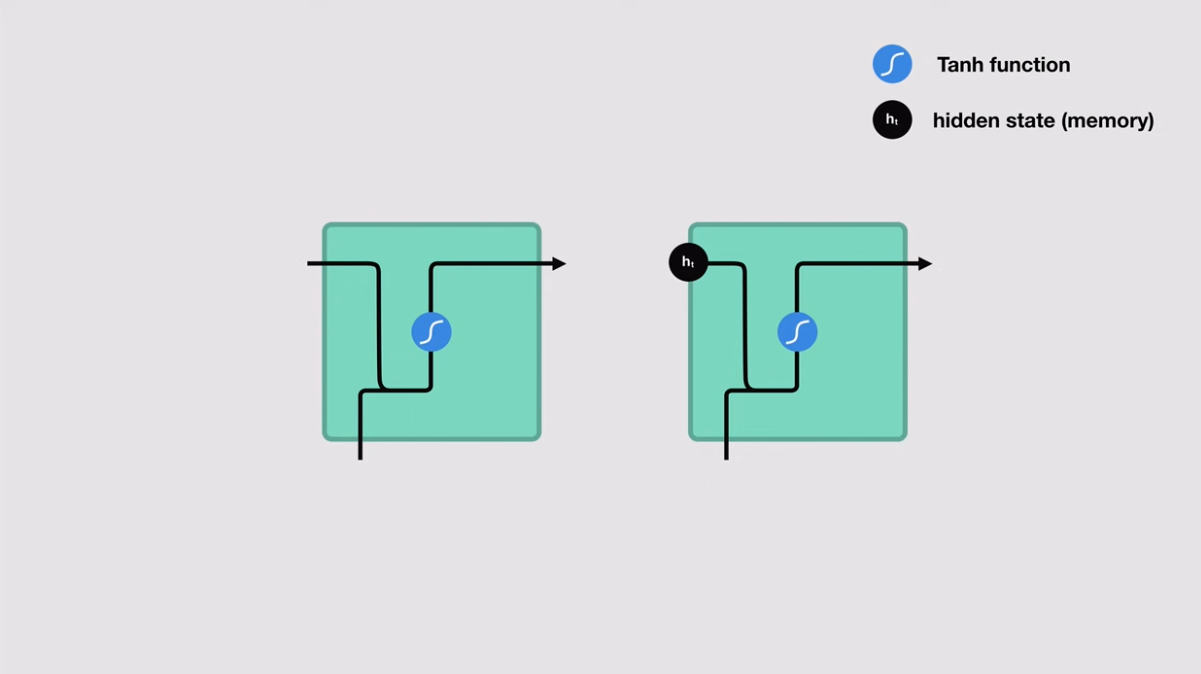

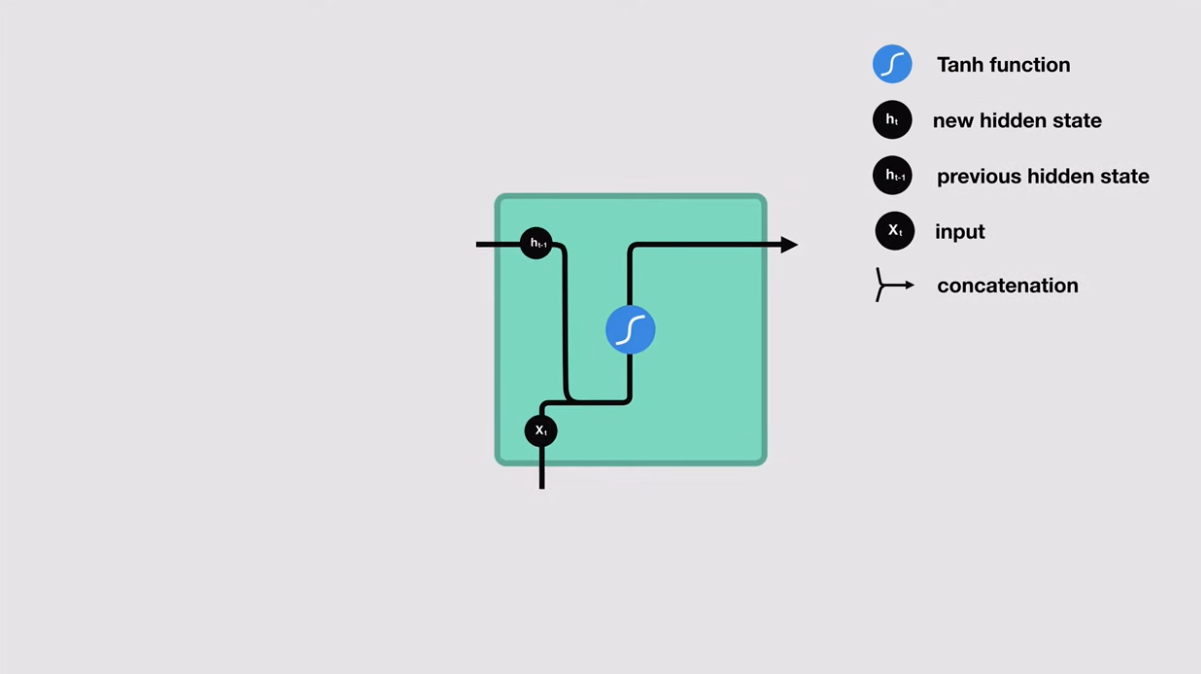

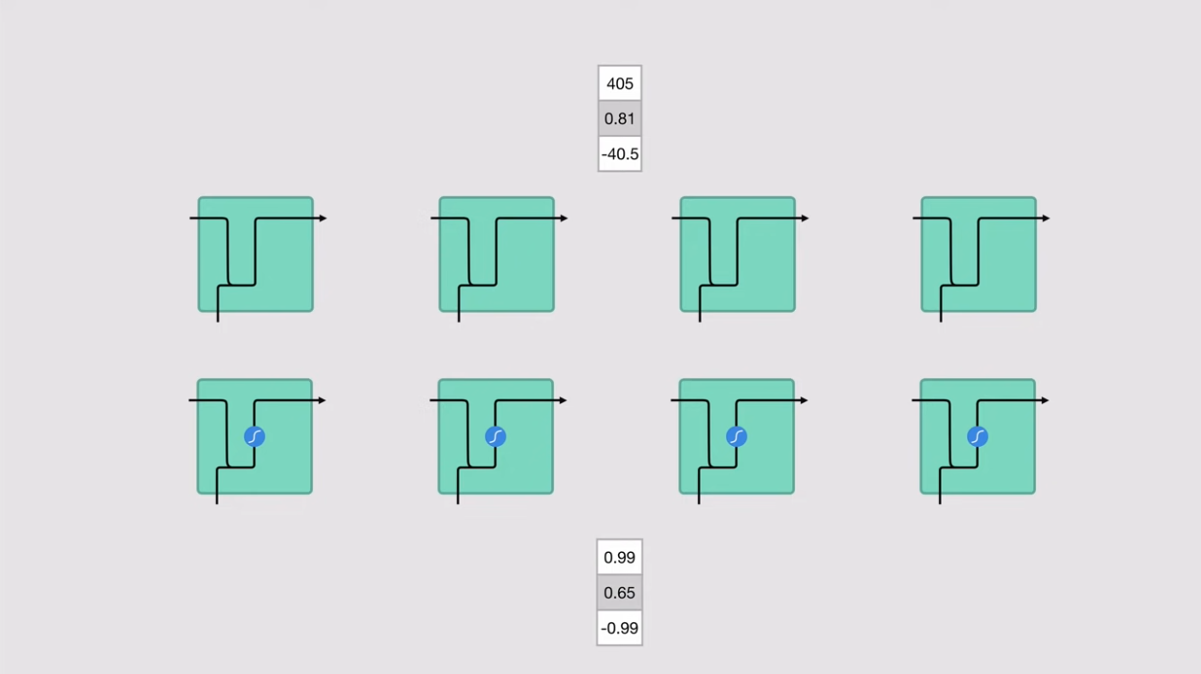

## The RNN learns on sequences. Therefore, we will have to adapt the problem statement. In this section, let’s work with the same data as in the previous chapter to get a good feel of how the data preparation and use of the data are different from fully connected architectures.

##Just to remember quickly: You have a dataset with measures on weather data, and we try to predict the temperature 12 hours (72 time steps of 10 minutes) into the future. Now what we did in the fully connected model was to create lagged variables. There was one y variable (which was not lagged), and the independent variables were lagged values of the y variable and a lot of other variables. The first lag was at 72 time steps, so that the model would use the data from 12 hours ago to predict the now (having a history from now to 12hours back to predict the now is equivalent to having data from now to predict 12 hours later).

## **Predicting a Sequence Rather Than a Value**

##In the RNN, this is not what we should do, as the RNN learns sequences. A big jump of 72 time steps is not really respecting the sequential variation. Yet we do not just want to predict one time step later, as that would mean that we predict the temperature in 10 minutes from now, not really interesting.

##What we will do is create a matrix of y variables, with lags as well. Before, we wanted to predict one value 72 time steps into the future, but let’s model to predict each of those 72. Even though it might be possible to do it with one y variable, this is also an interesting case of multistep forecasting, which is often useful.

## **Univariate Model Rather Than Multivariable**

## Another thing that we change from the previous model is that in this case, we will use only the temperature data and not the other variables. This may make the task slightly harder to accomplish, but it’ll be easier to get your head around the use of sequences and RNNs. However, you must know that it is possible to add other explanatory variables into an RNN. For forecasting tomorrow’s temperature, you may want to use not only today’s temperature but also today’s wind direction, wind speed, and humidity, for example. In this case, you could add a third dimension to the input data.

In [1]:
import keras
import pandas as pd

from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
del zip_file

13568290/13568290 [==============================] - 0s 0us/step


In [2]:
#Keep only temperature data

df = df[['T (degC)']]



In [3]:
#Apply a MinMaxScaler

# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])



In [4]:
#Preparing the sequence data

ylist = list(df['T'])

n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1

# converting list of lists to numpy array
import numpy as np
X_new = np.array(X_new)
y_new = np.array(y_new)



In [5]:
#Splitting train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)



In [6]:
#Reshape the data to be recognized by keras

batch_size = 32

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )

X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 72)                648       
                                                                 
Total params: 728 (2.84 KB)
Trainable params: 728 (2.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
7040/7040 [==============================] - 905s 128ms/step - loss: 0.0504 - mean_absolute_error: 0.0504 - val_loss: 0.0456 - val_mean_absolute_error: 0.0456
Epoch 2/5
7040/7040 [==============================] - 882s 125ms/step - loss: 0.0456 - mean_absolute_error: 0.0456 - val_loss: 0.0451 - val_mean_absolute_error: 0.0451
Epoch 3/5
7040/7040 [==============================] - 871s 124ms/step - loss: 0.044

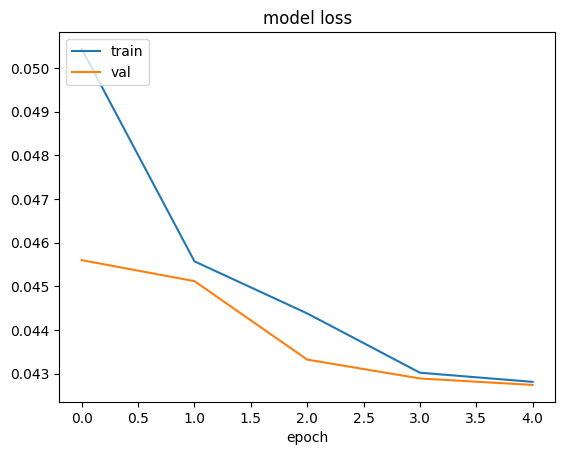

In [7]:
#Parametetrize a small network with SimpleRNN

import random
random.seed(42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

simple_model = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])


simple_model.summary()

simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

from sklearn.metrics import r2_score
print(r2_score(preds, y_test))

import matplotlib.pyplot as plt
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
#A more complex network with three layers of SimpleRNN

random.seed(42)

simple_model = Sequential([
  SimpleRNN(32, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(32, activation='tanh', return_sequences = True),
  SimpleRNN(32, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 216, 32)           1088      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 216, 32)           2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 72)                2376      
                                                                 
Total params: 7624 (29.78 KB)
Trainable params: 7624 (29.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
7040/7040 [==============================] - 3402s 483ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0314 - val_mean_absol

## **LSTM & GRUs RNNs**

## LSTMs (**Long-Short-Term-Memory**) and GRUs(**Gated-Recurrent-Unit**) are another RNN cell type.

![grafik.png](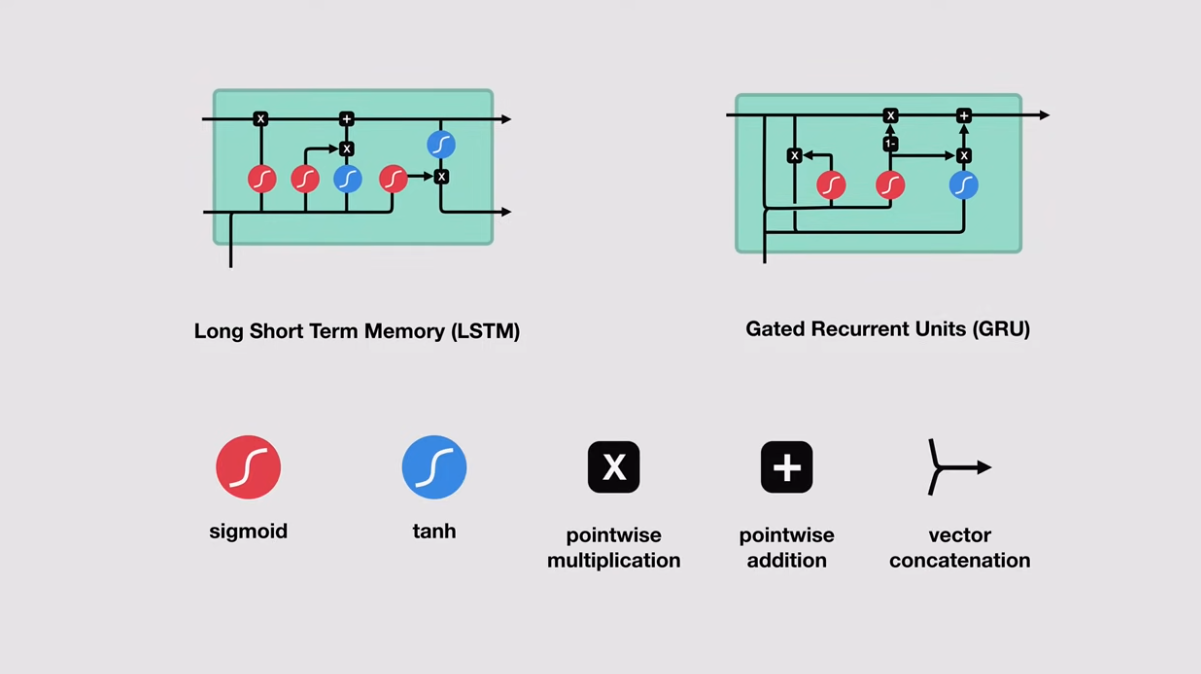
)

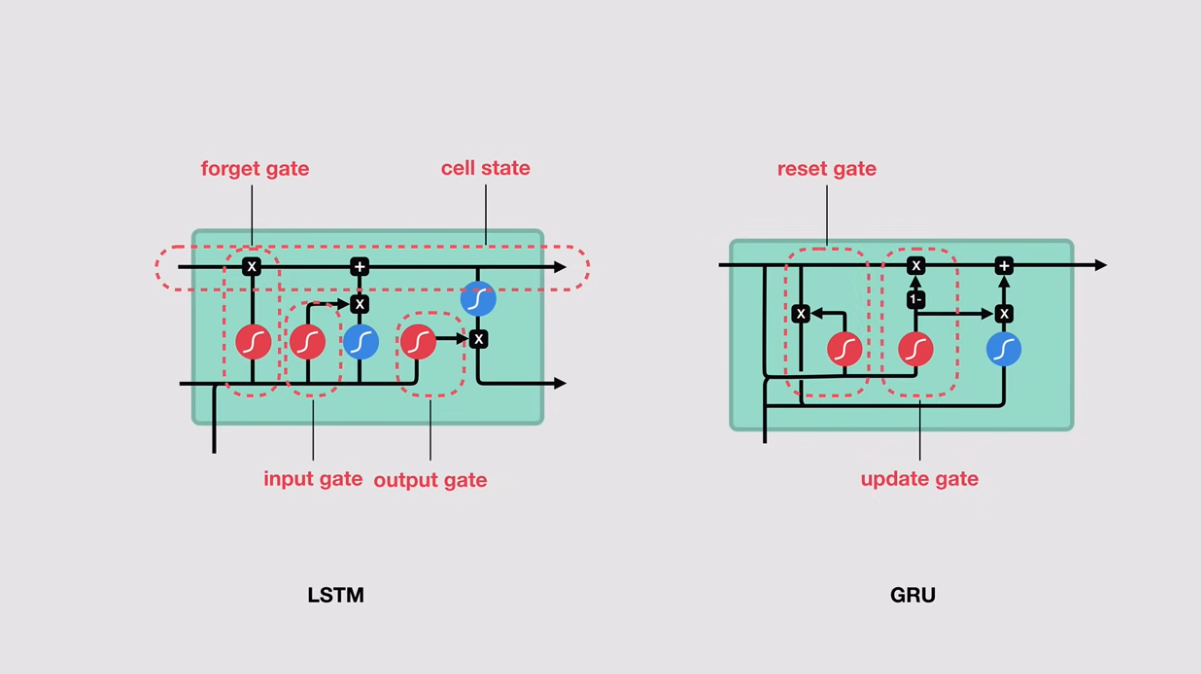

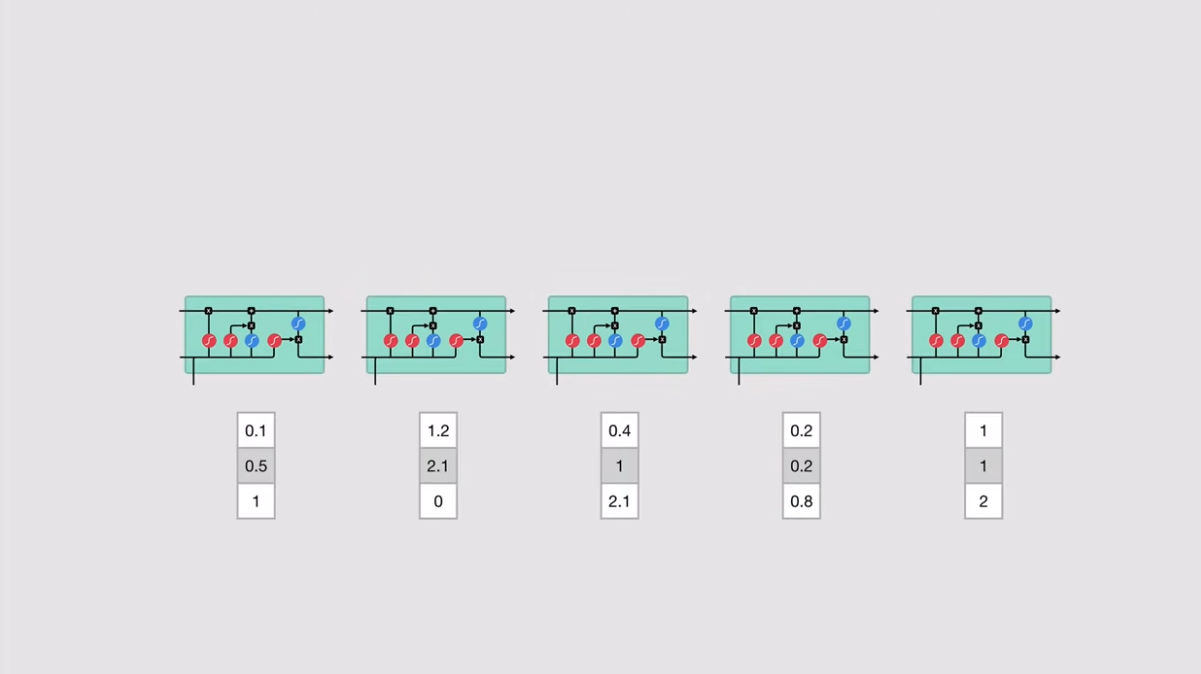

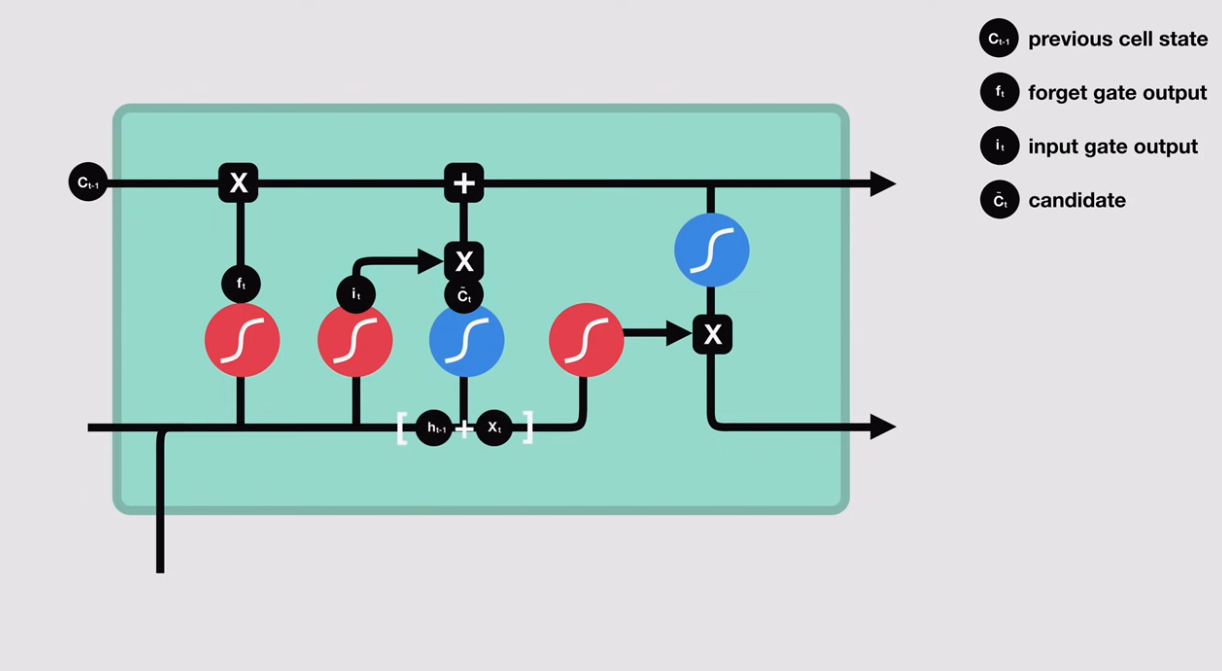

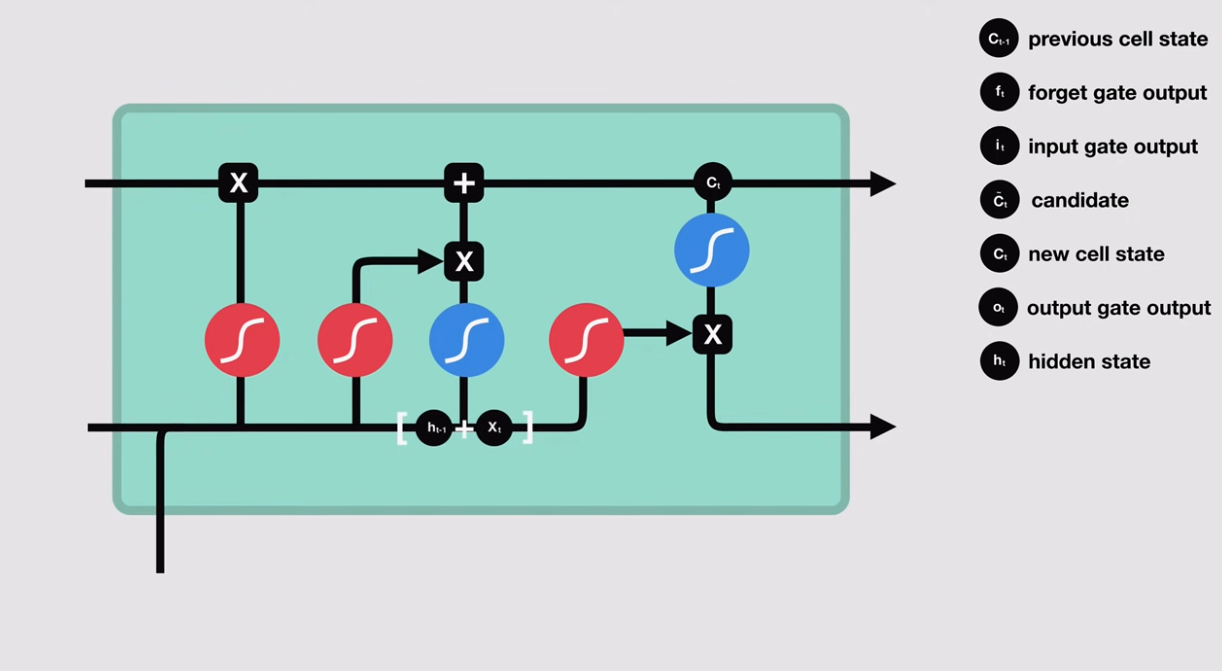

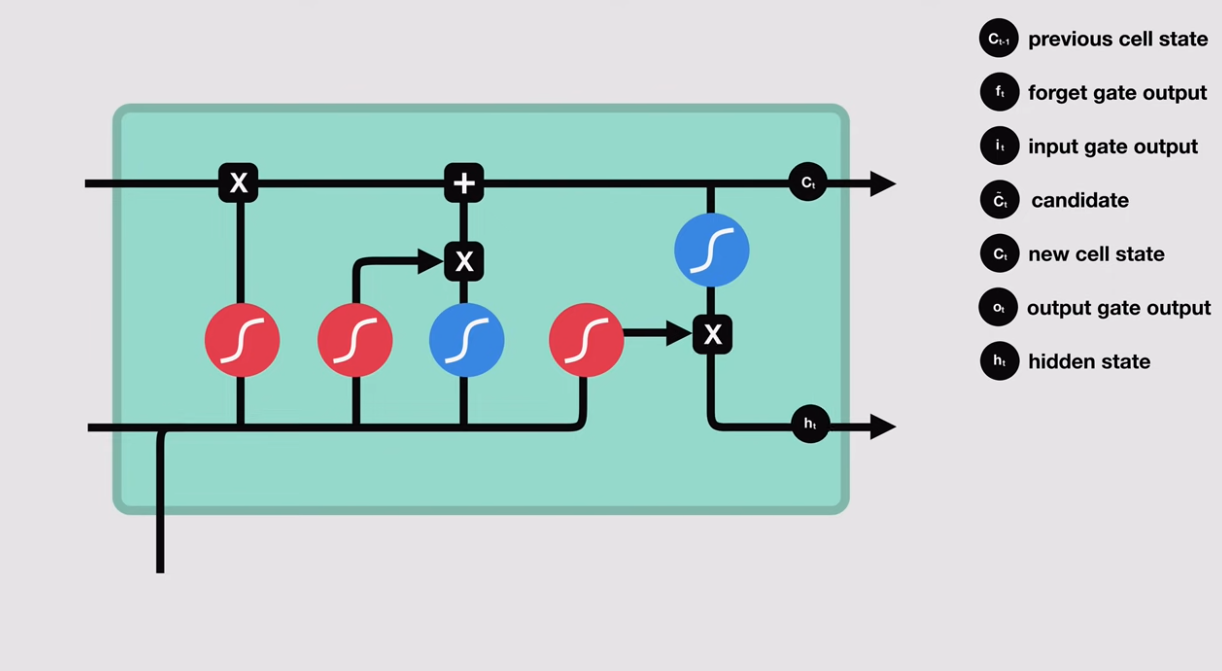

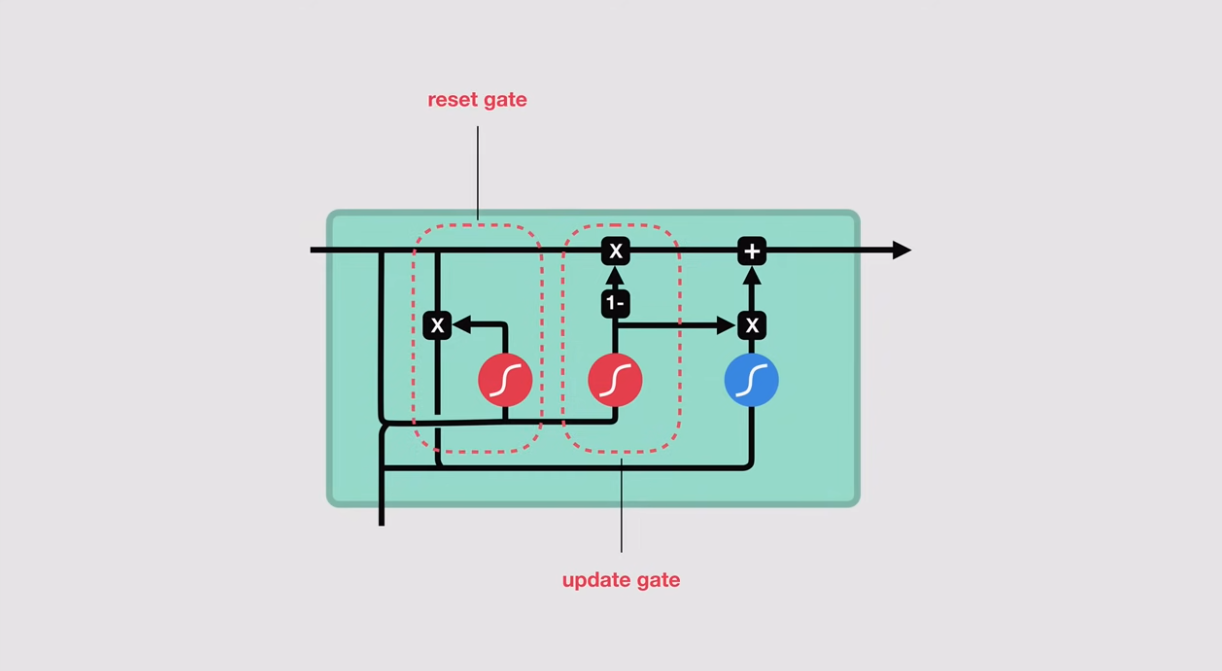

In [ ]:
#A simple architecture with 1 GRU layer

import random
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt





random.seed(42)
from tensorflow.keras.layers import GRU

simple_model = Sequential([
   GRU(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

# Check for NaN values in predictions or test target values
if np.isnan(preds).any() or np.isnan(y_test).any():
    print("Warning: NaN values present in predictions or test target values.")
else:
    r2 = r2_score(y_test, preds)
    print(f"R-squared score: {r2}")

# Plot the training history
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# A more complex network with three layers of GRU

random.seed(42)

simple_model = Sequential([
    GRU(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    GRU(64, activation='tanh', return_sequences=True),
    GRU(64, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
#LSTMs
#Importing the weather data

import keras
import pandas as pd

from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
del zip_file


# retain only temperature
df = df[['T (degC)']]

# apply a min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

# convert to windowed data sets
ylist = list(df['T'])

n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1

import numpy as np
X_new = np.array(X_new)
y_new = np.array(y_new)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.33, random_state=42)

# reshape data into the right format for RNNs
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )



In [ ]:
#One-layer LSTM

import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
random.seed(42)

batch_size = 32
simple_model = Sequential([
   LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
Three-layer LSTM

random.seed(42)

simple_model = Sequential([
   LSTM(64, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(64, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=10,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)

print(r2_score(preds, y_test))

plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

